In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LayerNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.utils import to_categorical
import pandas as pd

In [2]:
import matplotlib.pyplot as plt

def plot_history(history, title):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy Plot
    axs[0].plot(history.history['accuracy'], label="Train Accuracy")
    axs[0].plot(history.history['val_accuracy'], label="Validation Accuracy")
    axs[0].set_title(f"Model Accuracy - {title}")
    axs[0].set_xlabel("Epochs")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend()

    # Loss Plot
    axs[1].plot(history.history['loss'], label="Train Loss")
    axs[1].plot(history.history['val_loss'], label="Validation Loss")
    axs[1].set_title(f"Model Loss - {title}")
    axs[1].set_xlabel("Epochs")
    axs[1].set_ylabel("Loss")
    axs[1].legend()

    plt.show()

In [ ]:
# Load Data
df = pd.read_csv("stroke_features.csv")

In [5]:
df.head()

,HipAngles,KneeAngles,AnkleAngles,Subject,Label,HipAngles_Variability,KneeAngles_Variability,AnkleAngles_Variability,HipAngles_Acceleration,KneeAngles_Acceleration,AnkleAngles_Acceleration
0,30.049283,11.570827,-2.482850,Sub01,0,16.378885,16.962906,8.289713,0.000000,0.000000,0.000000
1,30.037282,11.714903,-2.519216,Sub01,0,16.378885,16.962906,8.289713,-0.012002,0.144076,-0.036365
2,30.024681,11.858510,-2.555104,Sub01,0,16.378885,16.962906,8.289713,-0.012600,0.143607,-0.035889
3,30.011461,12.001644,-2.590505,Sub01,0,16.378885,16.962906,8.289713,-0.013220,0.143134,-0.035401
4,29.997598,12.144301,-2.625407,Sub01,0,16.378885,16.962906,8.289713,-0.013863,0.142657,-0.034902


In [ ]:
# Separate Features & Labels
X = df.drop(columns=["Label","Subject"])
y = df["Label"]

In [7]:
X.head()

,HipAngles,KneeAngles,AnkleAngles,HipAngles_Variability,KneeAngles_Variability,AnkleAngles_Variability,HipAngles_Acceleration,KneeAngles_Acceleration,AnkleAngles_Acceleration
0,30.049283,11.570827,-2.482850,16.378885,16.962906,8.289713,0.000000,0.000000,0.000000
1,30.037282,11.714903,-2.519216,16.378885,16.962906,8.289713,-0.012002,0.144076,-0.036365
2,30.024681,11.858510,-2.555104,16.378885,16.962906,8.289713,-0.012600,0.143607,-0.035889
3,30.011461,12.001644,-2.590505,16.378885,16.962906,8.289713,-0.013220,0.143134,-0.035401
4,29.997598,12.144301,-2.625407,16.378885,16.962906,8.289713,-0.013863,0.142657,-0.034902


In [4]:
from sklearn.decomposition import PCA

# ✅ Apply PCA - SAME number of components as QNN input
num_pca_components = 4  # Adjust to match QNN's input size
pca = PCA(n_components=num_pca_components)
X_pca = pca.fit_transform(X)

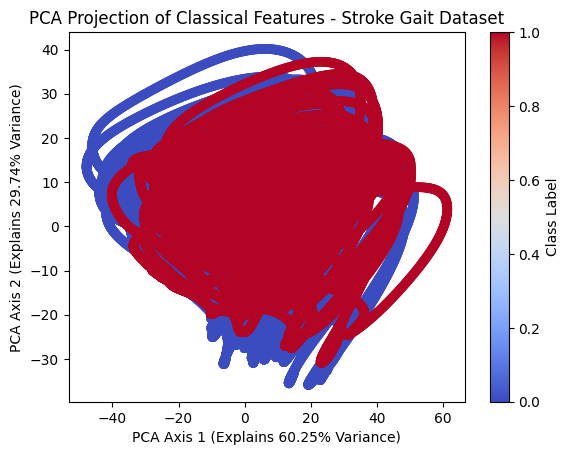

In [11]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap="coolwarm")
plt.xlabel("PCA Axis 1 (Explains {:.2f}% Variance)".format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel("PCA Axis 2 (Explains {:.2f}% Variance)".format(pca.explained_variance_ratio_[1] * 100))
plt.title("PCA Projection of Classical Features - Stroke Gait Dataset")
plt.colorbar(label="Class Label")
plt.show()

In [ ]:
# Convert labels to one-hot encoding
num_classes = 2  # Adjust for your dataset
y_onehot = to_categorical(y, num_classes=num_classes)

# Split into Train/Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_onehot, test_size=0.2, random_state=42)

In [8]:
# Sequential model (LSTM)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss="binary_crossentropy",
              metrics=["accuracy"])

# Train
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32, verbose=1)

Epoch 1/20
2503/2503 [==============================] - 22s 6ms/step - loss: 0.5798 - accuracy: 0.7040 - val_loss: 0.5397 - val_accuracy: 0.7251
Epoch 2/20
2503/2503 [==============================] - 15s 6ms/step - loss: 0.5165 - accuracy: 0.7362 - val_loss: 0.4993 - val_accuracy: 0.7437
Epoch 3/20
2503/2503 [==============================] - 13s 5ms/step - loss: 0.4922 - accuracy: 0.7493 - val_loss: 0.4841 - val_accuracy: 0.7542
Epoch 4/20
2503/2503 [==============================] - 21s 8ms/step - loss: 0.4822 - accuracy: 0.7553 - val_loss: 0.4792 - val_accuracy: 0.7561
Epoch 5/20
2503/2503 [==============================] - 22s 9ms/step - loss: 0.4770 - accuracy: 0.7584 - val_loss: 0.4793 - val_accuracy: 0.7586
Epoch 6/20
2503/2503 [==============================] - 18s 7ms/step - loss: 0.4724 - accuracy: 0.7630 - val_loss: 0.4679 - val_accuracy: 0.7630
Epoch 7/20
2503/2503 [==============================] - 21s 8ms/step - loss: 0.4683 - accuracy: 0.7666 - val_loss: 0.4651 - val_ac

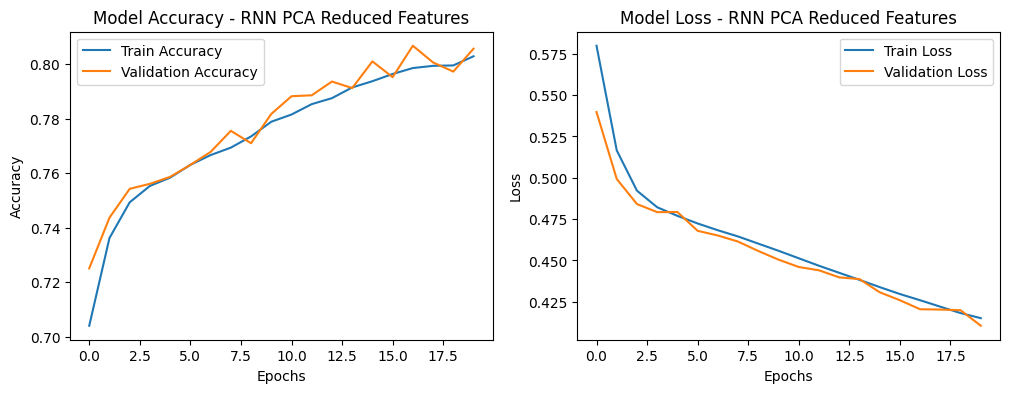

In [9]:
plot_history(history, "RNN PCA Reduced Features")

626/626 [==============================] - 2s 2ms/step


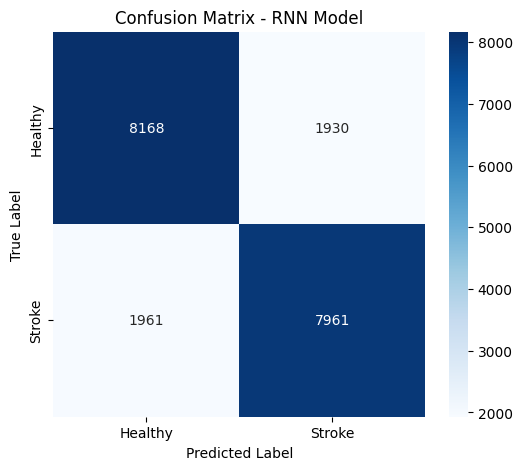

Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.81      0.81     10098
           1       0.80      0.80      0.80      9922

    accuracy                           0.81     20020
   macro avg       0.81      0.81      0.81     20020
weighted avg       0.81      0.81      0.81     20020



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Step 1: Get Model Predictions
y_pred_probs = model.predict(X_test)  # Get prediction probabilities


# Step 2: Adjust Decision Threshold
threshold = 0.5
y_pred = (y_pred_probs[:, 0] > threshold).astype(int)

# Step 3: Convert one-hot encoded labels (if needed)
if len(y_test.shape) > 1 and y_test.shape[1] > 1:  # Check safely
    y_test = np.argmax(y_test, axis=1)  # Converts one-hot labels back to single-class


# Step 4: Compute Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Step 5: Visualize Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Stroke"], yticklabels=["Healthy", "Stroke"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - RNN Model")
plt.show()

# 🔹 Step 6: Print Classification Report
print("Classification Report:\n", classification_report(y_test, y_pred))

In [11]:
# ✅ Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"DNN Test Accuracy: {test_acc:.4f} | Loss: {test_loss:.4f}")

626/626 [==============================] - 2s 4ms/step - loss: 0.4106 - accuracy: 0.8056
DNN Test Accuracy: 0.8056 | Loss: 0.4106


In [12]:
# Get model predictions
y_pred_probs = model.predict(X_test)

# Check confidence distribution
print("Min Confidence:", np.min(y_pred_probs))
print("Max Confidence:", np.max(y_pred_probs))
print("Mean Confidence:", np.mean(y_pred_probs))

626/626 [==============================] - 1s 2ms/step
Min Confidence: 0.00025531245
Max Confidence: 0.99785775
Mean Confidence: 0.5036442


626/626 [==============================] - 1s 2ms/step


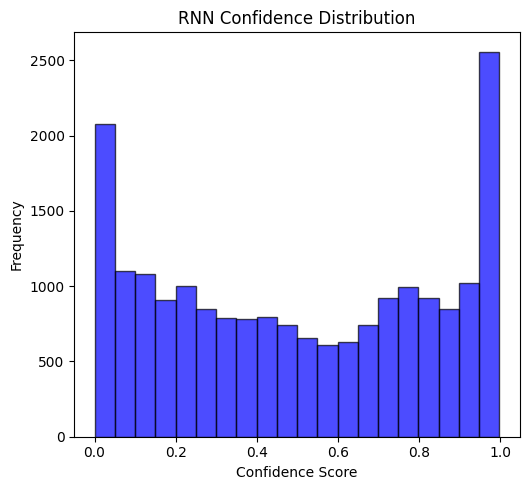

In [13]:
y_true_qnn = y_test  # Convert one-hot labels to class labels
y_pred_qnn = np.argmax(model.predict(X_test), axis=1)
confidences_qnn = np.max(model.predict(X_test), axis=1)

# Convert to numpy arrays if needed
qnn_confidences = np.array(confidences_qnn)  # Replace with your QNN confidence list

plt.figure(figsize=(10, 5))

# QNN Confidence Distribution
plt.subplot(1, 2, 1)
plt.hist(qnn_confidences, bins=20, color='blue', alpha=0.7, edgecolor='black')
plt.title("RNN Confidence Distribution")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


# K-Fold

In [15]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# Define number of folds
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store metrics
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

# Placeholder for epoch-wise averaging
all_train_acc = []
all_val_acc = []
all_train_loss = []
all_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"\nTraining Fold {fold+1}/{k}")

    # Split data
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = y_train[train_idx], y_train[val_idx]

    # Sequential model (LSTM)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss="binary_crossentropy",
                metrics=["accuracy"])

    # Train model
    history = model.fit(X_train_fold, y_train_fold, 
                        epochs=20, batch_size=32, 
                        validation_data=(X_val_fold, y_val_fold), 
                        verbose=1)

    # Store per-epoch results
    train_accuracies.append(history.history['accuracy'])
    val_accuracies.append(history.history['val_accuracy'])
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Evaluate model
    _, accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
    print(f"Fold {fold+1} Accuracy: {accuracy:.4f}")


Training Fold 1/5
Epoch 1/20
2002/2002 [==============================] - 12s 5ms/step - loss: 0.5937 - accuracy: 0.6845 - val_loss: 0.5473 - val_accuracy: 0.7217
Epoch 2/20
2002/2002 [==============================] - 10s 5ms/step - loss: 0.5308 - accuracy: 0.7271 - val_loss: 0.5172 - val_accuracy: 0.7355
Epoch 3/20
2002/2002 [==============================] - 13s 6ms/step - loss: 0.5051 - accuracy: 0.7438 - val_loss: 0.4949 - val_accuracy: 0.7440
Epoch 4/20
2002/2002 [==============================] - 15s 7ms/step - loss: 0.4916 - accuracy: 0.7527 - val_loss: 0.4895 - val_accuracy: 0.7561
Epoch 5/20
2002/2002 [==============================] - 14s 7ms/step - loss: 0.4844 - accuracy: 0.7569 - val_loss: 0.4797 - val_accuracy: 0.7661
Epoch 6/20
2002/2002 [==============================] - 11s 6ms/step - loss: 0.4796 - accuracy: 0.7591 - val_loss: 0.4758 - val_accuracy: 0.7650
Epoch 7/20
2002/2002 [==============================] - 11s 6ms/step - loss: 0.4758 - accuracy: 0.7612 - val_lo


Final K-Fold Accuracy: 0.7923


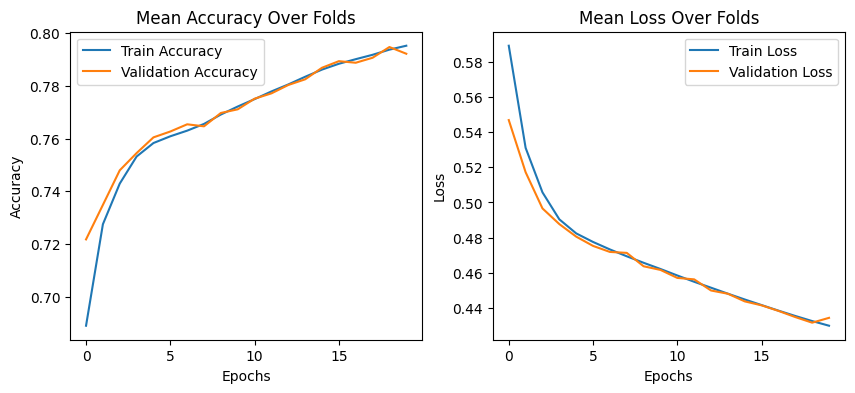

In [16]:
# Convert lists to NumPy arrays for easy averaging
train_accuracies = np.array(train_accuracies)
val_accuracies = np.array(val_accuracies)
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

# Compute mean accuracy/loss across folds
mean_train_acc = np.mean(train_accuracies, axis=0)
mean_val_acc = np.mean(val_accuracies, axis=0)
mean_train_loss = np.mean(train_losses, axis=0)
mean_val_loss = np.mean(val_losses, axis=0)

# 🎯 Final mean accuracy across folds
final_accuracy = np.mean(val_accuracies[:, -1])
print(f"\nFinal K-Fold Accuracy: {final_accuracy:.4f}")

# 📊 Plot Accuracy Curves
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(mean_train_acc, label='Train Accuracy')
plt.plot(mean_val_acc, label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy Over Folds")
plt.legend()

# 📊 Plot Loss Curves
plt.subplot(1, 2, 2)
plt.plot(mean_train_loss, label='Train Loss')
plt.plot(mean_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Mean Loss Over Folds")
plt.legend()

plt.show()

In [17]:
import pandas as pd
import numpy as np

# Convert lists to numpy arrays
folds = list(range(1, len(train_accuracies) + 1))

# Create DataFrame with results per fold
df_results = pd.DataFrame({
    'Fold': folds,
    'Final Train Accuracy': [train_acc[-1] for train_acc in train_accuracies],
    'Final Validation Accuracy': [val_acc[-1] for val_acc in val_accuracies],
    'Final Train Loss': [train_loss[-1] for train_loss in train_losses],
    'Final Validation Loss': [val_loss[-1] for val_loss in val_losses]
})

# Print results
print("\n📊 K-Fold Cross-Validation Results:\n")
print(df_results)

# Compute summary statistics (mean & std deviation)
df_summary = df_results.describe().loc[['mean', 'std']]
print("\n📌 Summary Statistics (Mean & Std Deviation):\n")
print(df_summary)

# Save results to CSV
df_results.to_csv("kfold_results.csv", index=False)
df_summary.to_csv("kfold_summary.csv", index=False)

print("\n✅ Results saved as 'kfold_results.csv' and 'kfold_summary.csv'")


📊 K-Fold Cross-Validation Results:

   Fold  Final Train Accuracy  Final Validation Accuracy  Final Train Loss  \
0     1              0.794190                   0.799138          0.429778   
1     2              0.796297                   0.785902          0.430658   
2     3              0.795033                   0.791146          0.431315   
3     4              0.797265                   0.787463          0.427665   
4     5              0.793722                   0.797640          0.430086   

   Final Validation Loss  
0               0.427228  
1               0.439595  
2               0.437734  
3               0.439133  
4               0.428226  

📌 Summary Statistics (Mean & Std Deviation):

          Fold  Final Train Accuracy  Final Validation Accuracy  \
mean  3.000000              0.795302                   0.792258   
std   1.581139              0.001471                   0.005936   

      Final Train Loss  Final Validation Loss  
mean          0.429901             